# Adversarial Search: Playing "Mean" Connect 4


## Instructions

All student names in group: [Liana Torpey, Blake Lewinski]

I understand that my submission needs to be my own group's work: [LGT, BCL]

I understand that ChatGPT / Copilot / other AI tools are not allowed: [LGT, BCL]

Points: 10

Complete this notebook and submit it (save/print as pdf). The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard connect 4.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Initial state: The initial state of the game is an empty board with 6 rows and 7 columns, where no disks are placed. (Or n rows and m columns could describe the initial state of the room.)

Actions: In Mean Connect 4, the actions involve either placing a disk of the player's color into one of the columns (if the column is not full), or performing a "mean move" by taking an opponent's disk from the bottom row of a column and placing it on top of the same column. Players alternate turns, so the action space depends on the current state of the board and whether a mean move is available. It is also dependent on the fact that once a move is made, the next move cannot also be a mean move.

Transition model: The transition model describes how actions change the current state. When a player places a disk into a column, it falls to the lowest available position in that column. If a mean move is performed, the opponent's disk from the bottom row is removed and placed on top, causing the disks above it to fall down.

Test for the terminal state: The game terminates when one player achieves a winning condition (four consecutive disks of their color in a row, column, or diagonal) or when the board is filled with disks and no winning condition is met. In addition, if both players decide to pass their turn for a certain number of times (indicating a deadlock situation), the game may also terminate. Also, if a mean move results in a tie then the game terminates immediately, and none of the players win even if one player has more connected fours than the other.

Utility for terminal states: In Mean Connect 4, the utility function assigns a value to terminal states based on the outcome of the game. Typically, a win for the player is assigned a positive utility, a win for the opponent is assigned a negative utility, and a draw is assigned a neutral utility.

How big is the state space? Give an estimate and explain it.

State Space Estimate:
In the mean version of Connect 4, the state space is significantly larger than the standard Connect 4 due to the mean move option.

Columns: 7 columns (standard Connect 4)
Rows: 6 rows (standard Connect 4)
Possible Disks in a Cell: 3 (empty, player's disk, opponent's disk)
Mean Move Option: For each player's turn, they can choose to make a regular move or a mean move.

Considering these factors, the total state space can be estimated as:
3^(42) * 2
(since there are 42 cells and each cell can be in one of three states, and there are two players who can make a move

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Branching Factor:
In standard Connect 4, the branching factor is approximately 7 (the number of columns). However, in Mean Connect 4, the branching factor effectively doubles since players have two types of moves to consider: dropping a disc or performing a mean move. Therefore, the branching factor is around 14.

Depth of the Tree:
The depth of the game tree varies based on the number of moves made and the number of mean moves performed. Estimating the average depth of the tree is challenging due to the dynamic nature of the game. However, it's safe to assume that the depth could be around 21 moves or more, considering that players have 21 opportunities to play, and mean moves might prolong the game.

Given these estimates, the size of the game tree can be approximated as:

Size of Game Tree ≈ (Branching Factor)^Depth of Tree

Size of Game Tree ≈ 14^(21)

However, this is a rough estimate, and the actual size of the game tree could be smaller due to pruning strategies in the minimax algorithm and alpha-beta pruning, which can significantly reduce the number of nodes explored.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [ ]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

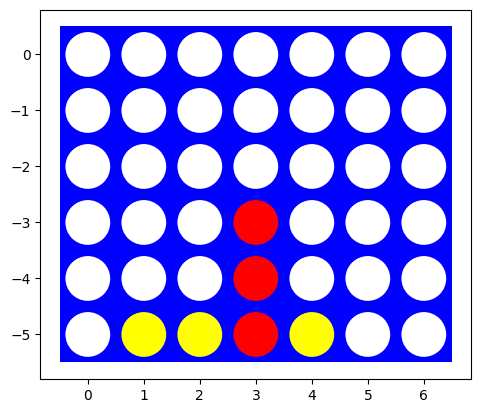

In [ ]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle = plt.Rectangle((-0.5, len(board) * -1 + 0.5), len(board[0]), len(board), fc='blue')
    circles = []
    for i, row in enumerate(board):
        for j, val in enumerate(row):
            color = 'white' if val == 0 else 'red' if val == 1 else 'yellow'
            circles.append(plt.Circle((j, i * -1), 0.4, fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [ ]:
# Function to check if a column is valid for placing a disk
def is_valid_column(board, column):
    return board[0, column] == 0

# Function to find the next available row in a column
def find_next_row(board, column):
    for row in range(board.shape[0] - 1, -1, -1):
        if board[row, column] == 0:
            return row
    return -1

# Function to apply the mean move
def apply_mean_move(board, column, player):
    print("************ MEAN MOVE IS EXECUTED ****************")
    if board[-1, column] != -player:
        return False  # Mean move cannot be applied if the bottom row disk is not of the opponent

    for row in range(board.shape[0] - 2, -1, -1):
        board[row + 1, column] = board[row, column]

    # Place the opponent's piece at the top of the column
    board[0, column] = -player

    return True

# Function to apply a player's move
def apply_player_move(board, column, player):
    row = find_next_row(board, column)
    board[row, column] = player

# Function to check for terminal states
def terminal(board):
    if np.all(board != 0):
        return True
    if check_winner(board, 1) or check_winner(board, -1):
        return True
    return False

# Function to get available actions
def actions(board):
    board_array = np.array(board)  # Convert the board to a NumPy array
    available_actions = []
    for col in range(board_array.shape[1]):
        if is_valid_column(board_array, col):
            available_actions.append(col)
    return available_actions

# Function to get the utility of a terminal state
def utility(board):
    if check_winner(board, 1):
        return 1
    elif check_winner(board, -1):
        return -1
    else:
        return 0

# Function to check if a player has won
def check_winner(board, player):
    # Check horizontal
    for row in range(board.shape[0]):
        for col in range(board.shape[1] - 3):
            if np.all(board[row, col:col + 4] == player):
                return True

    # Check vertical
    for col in range(board.shape[1]):
        for row in range(board.shape[0] - 3):
            if np.all(board[row:row + 4, col] == player):
                return True

    # Check diagonal (positive slope)
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            if np.all(board[row:row + 4, col + np.arange(4)] == player):
                return True

    # Check diagonal (negative slope)
    for row in range(3, board.shape[0]):
        for col in range(board.shape[1] - 3):
            if np.all(board[row - np.arange(4), col + np.arange(4)] == player):
                return True

    # Check negative diagonal (backslash pattern)
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            if np.all(board[row:row + 4, col:col + 4].diagonal() == player):
                return True

    return False

# Transition model result function
def result(state, action, player):
    new_state = state.copy()
    if action == 'mean':
        for col in range(new_state.shape[1]):
            if new_state[-1, col] == -player:
                if apply_mean_move(new_state, col, player):
                    return new_state  # Mean move applied successfully, return the new state
    elif action is not None:
        row = find_next_row(new_state, action)
        if row != -1:
            new_state[row, action] = player
    return new_state

Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [ ]:
# Random player agent function
def random_player(state, player=None):
    available_actions = actions(state)
    return np.random.choice(available_actions)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [ ]:
# Function to play a game between two agents
def play_game():
    board = empty_board()  # Initialize the board
    players = [1, -1]  # Players: 1 for red, -1 for yellow
    mean_move_used = False

    while not terminal(board):
        for player in players:
            action = random_player(board, player)
            if isinstance(action, tuple) and action[0] == 'mean':
                if mean_move_used:
                    # If a mean move was already used, end the game in a draw
                    return 0
                mean_move_used = True

            board = result(board, action, player)

            if terminal(board):
                break

    return utility(board)  # Return the utility of the terminal state

# Main function to run the experiment
if __name__ == "__main__":
    num_games = 1000
    wins = {1: 0, -1: 0, 0: 0}  # Dictionary to store the wins for each player and draws

    for _ in range(num_games):
        winner = play_game()
        wins[winner] += 1

    # Print the results
    print("Player 1 (Red) wins:", wins[1])
    print("Player -1 (Yellow) wins:", wins[-1])
    print("Draws:", wins[0])

Player 1 (Red) wins: 555
Player -1 (Yellow) wins: 442
Draws: 3


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
# Minimax with Alpha-Beta pruning
def minimax_ab(board, depth, alpha, beta, maximizing_player, original_player):
    if terminal(board) or depth == 0:
        return None, utility(board)

    best_action = None
    if maximizing_player:
        max_eval = -np.inf
        for action in actions(board):
            new_board = result(board, action, original_player)
            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, False, original_player)
            if eval_score > max_eval:
                max_eval = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning
        return best_action, max_eval
    else:
        min_eval = np.inf
        for action in actions(board):
            new_board = result(board, action, -original_player)
            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True, original_player)
            if eval_score is not None and eval_score < min_eval:
                min_eval = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning
        return best_action, min_eval

def minimax_player(state, player=None, depth=3):
    maximizing_player = (player == 1)
    best_action = None
    alpha = -np.inf
    beta = np.inf

    if maximizing_player:
        best_score = -np.inf
        for action in actions(state):
            new_board = result(state, action, player)

            # Check for immediate mean move win
            if action == 'mean' and check_mean_move_win(new_board, player):
                return 'mean'

            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, False, player)

            if eval_score is not None and eval_score > best_score:
                best_score = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning

    else:
        best_score = np.inf
        mean_move_available = False
        for action in actions(state):
            new_board = result(state, action, player)
            if action == 'mean':
                mean_move_available = True
                if check_winner(new_board, player):
                    return 'mean'  # If mean move can lead to a win, take it immediately
                _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True, player)
            else:
                _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True, player)

            if eval_score is not None and eval_score < best_score:
                best_score = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning

        if best_action is None and mean_move_available:
            best_action = 'mean'

    return best_action

def check_mean_move_win(board, player):
    for col in range(board.shape[1] - 3):
        for row in range(board.shape[0] - 3):
            if np.all(board[row:row + 4, col:col + 4] == player):
                return True
    return False

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Testing Sample Board 1
Player 1 has won!


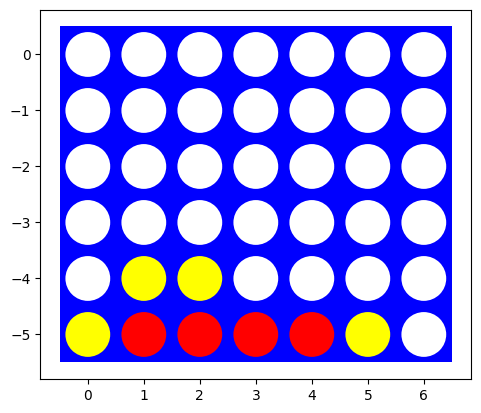

Moves for Player 1:
[4]
Moves for Player 2:
[]
Testing Sample Board 2
Player 1 has won!


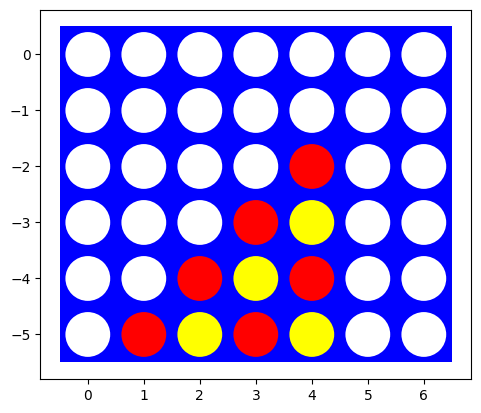

Moves for Player 1:
[4]
Moves for Player 2:
[]
Testing Sample Board 3
Player -1 has won!


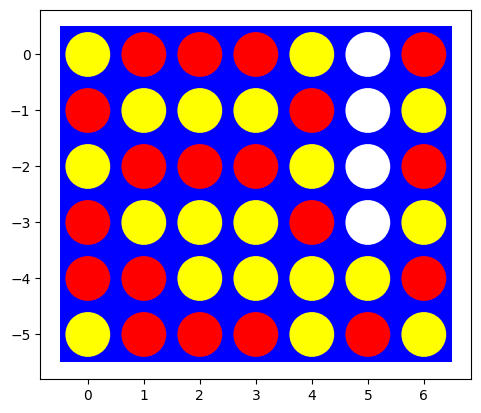

Moves for Player 1:
[0, 0, 1, 1, 1, 2, 2, 3, 3, 6, 6, 6, 4, 4, 5]
Moves for Player 2:
[0, 0, 1, 1, 2, 2, 3, 3, 6, 6, 6, 4, 4, 4, 5]
Testing Sample Board 4
Player 1 has won!


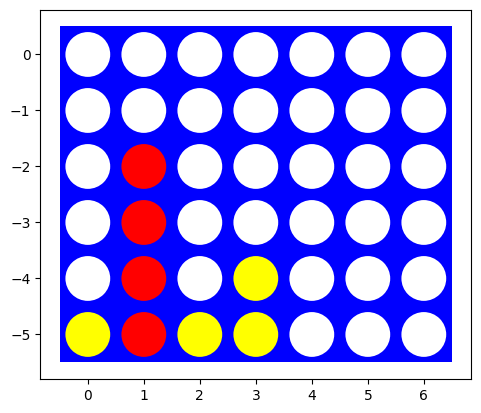

Moves for Player 1:
[1]
Moves for Player 2:
[]
Testing Sample Board 5
Player 1 has won!


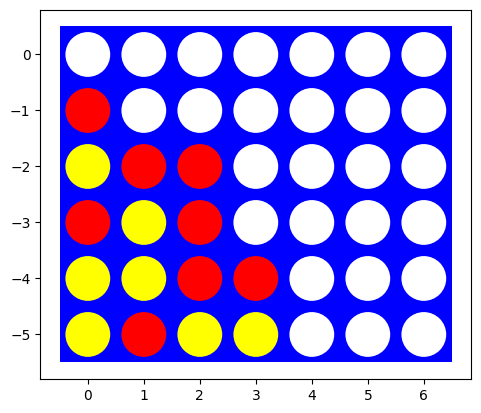

Moves for Player 1:
[2, 0, 0]
Moves for Player 2:
[0, 0]


In [ ]:
def create_board(board_config):
    return np.array(board_config)

if __name__ == "__main__":
    # Sample boards for testing
    sample_boards = [
    # Horizontal win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, -1, -1, 0, 0, 0, 0],
    [-1, 1, 1, 1, 0, -1, 0]],
    # Positive slope diagonal win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0],
    [0, 0, 1, -1, 1, 0, 0],
    [0, 1, -1, 1, -1, 0, 0]],
    # Mean move win opportunity for player 1
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, -1, -1, 0, 0, 0],
    [-1, 1, 1, 1, -1, 0, 0]],
    # Vertical win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, -1, 0, 0, 0],
    [-1, 1, -1, -1, 0, 0, 0]],
    # Negative slope diagonal win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, -1, 1, 0, 0, 0, 0],
    [0, -1, 1, 1, 0, 0, 0],
    [-1, 1, -1, -1, 0, 0, 0]]
    ]

    for i, board_config in enumerate(sample_boards):
      print(f"Testing Sample Board {i + 1}")
      board = create_board(board_config)

      player = 1  # Starting player
      moves_player1 = []  # List to store player 1 moves
      moves_player2 = []  # List to store player 2 moves
      while not terminal(board):
          current_board = board.copy()  # Create a copy of the board for the current player

          if player == 1:
              action = minimax_player(current_board, player=player, depth=4)
              if action == 'mean':
                  moves_player1.append('mean')
              else:
                  moves_player1.append(action)
          else:
              action = minimax_player(current_board, player=-player, depth=4)  # Pass -player for opponent
              if action == 'mean':
                  moves_player2.append('mean')
              else:
                  moves_player2.append(action)

          # Apply the selected move
          board = result(board, action, player)

          # Check if the move resulted in a win
          if check_winner(board, player):
              print(f"Player {player} has won!")
              break

          # Switch players
          player = -player

      # Print the final board state
      visualize(board)

      # Print the moves made by each player
      print("Moves for Player 1:")
      print(moves_player1)
      print("Moves for Player 2:")
      print(moves_player2)

      # Check if the game ended in a draw
      if terminal(board) and not check_winner(board, 1) and not check_winner(board, -1):
          print("The game ended in a draw!")

      print("=" * 30)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
import numpy as np
import time

# Function to check if a mean move results in an immediate win for the player
def check_mean_move_win(board, player):
    for col in range(board.shape[1] - 3):
        for row in range(board.shape[0]):
            # Check horizontally
            if np.all(board[row, col:col + 4] == player):
                return True

    return False

# Function to make a move and measure the time taken
def make_move_and_measure_time(board, player, depth=3):
    start_time = time.time()
    action = minimax_player(board, player, depth)
    end_time = time.time()

    if action == 'mean':
        apply_mean_move(board, board.shape[1] // 2)  # Apply mean move for the middle column
    else:
        apply_player_move(board, action, player)

    return end_time - start_time

# Test the time taken to make a move on boards of increasing size
for num_columns in range(4, 9):  # Increase board size from 4 to 8 columns
    board_size = (6, num_columns)  # Fixed number of rows (6)
    board = np.zeros(board_size, dtype=int)

    # Determine which player starts the game
    current_player = 1 if np.sum(board) == 0 else -1

    print(f"Board size: {board_size}")
    print("Time taken to make a move (in seconds):")
    print(make_move_and_measure_time(board, current_player))
    print()


Board size: (6, 4)
Time taken to make a move (in seconds):
0.01711297035217285

Board size: (6, 5)
Time taken to make a move (in seconds):
0.03594160079956055

Board size: (6, 6)
Time taken to make a move (in seconds):
0.06883835792541504

Board size: (6, 7)
Time taken to make a move (in seconds):
0.12271285057067871

Board size: (6, 8)
Time taken to make a move (in seconds):
0.20961666107177734



### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

Winning Moves: Prioritize moves that lead to an immediate win for the current player.
Blocking Moves: Prioritize moves that block the opponent from winning on the next turn.
Center Column: Prioritize the center column(s) as they offer more opportunities for future wins.
Other Columns: Prioritize other columns based on some heuristics like proximity to existing player pieces or avoidance of opponent pieces.

In [ ]:
def prioritized_actions(board, player):
    # Initialize lists for different types of moves
    winning_moves = []
    blocking_moves = []
    center_column = []
    other_columns = []

    # Prioritize winning moves
    for action in actions(board):
        new_board = result(board, action, player)
        if check_winner(new_board, player):
            winning_moves.append(action)

    # Prioritize blocking moves
    opponent = -player
    for action in actions(board):
        new_board = result(board, action, opponent)
        if check_winner(new_board, opponent):
            blocking_moves.append(action)

    # Prioritize center column
    center_column.extend([col for col in actions(board) if col == board.shape[1] // 2])

    # Prioritize other columns
    other_columns.extend([col for col in actions(board) if col != board.shape[1] // 2])

    # Concatenate lists based on priority
    ordered_actions = winning_moves + blocking_moves + center_column + other_columns

    return ordered_actions


def minimax_ab_ordered(board, depth, alpha, beta, maximizing_player, original_player):
    if terminal(board) or depth == 0:
        return None, utility(board)

    best_action = None
    if maximizing_player:
        max_eval = -np.inf
        for action in prioritized_actions(board, original_player):
            new_board = result(board, action, original_player)
            _, eval_score = minimax_ab_ordered(new_board, depth - 1, alpha, beta, False, original_player)
            if eval_score > max_eval:
                max_eval = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning
        return best_action, max_eval
    else:
        min_eval = np.inf
        for action in prioritized_actions(board, -original_player):
            new_board = result(board, action, -original_player)
            _, eval_score = minimax_ab_ordered(new_board, depth - 1, alpha, beta, True, original_player)
            if eval_score is not None and eval_score < min_eval:
                min_eval = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning
        return best_action, min_eval


def measure_move_time(board, player, depth, ordered=True):
    start_time = time.time()
    if ordered:
        minimax_ab_ordered(board, depth, -np.inf, np.inf, True, player)
    else:
        minimax_ab(board, depth, -np.inf, np.inf, True, player)
    end_time = time.time()
    return end_time - start_time


# Experiment to measure the influence of move ordering strategy on move time
depth = 4
board_size = (6, 7)
board = np.zeros(board_size, dtype=int)
player = 1

# Measure move time with move ordering strategy
time_with_ordering = measure_move_time(board, player, depth, ordered=True)

# Measure move time without move ordering strategy
time_without_ordering = measure_move_time(board, player, depth, ordered=False)

# Print the results in a table
print("| Move Ordering Strategy | Time Taken (seconds) |")
print("|------------------------|----------------------|")
print(f"| With ordering          | {time_with_ordering:.6f}           |")
print(f"| Without ordering       | {time_without_ordering:.6f}           |")

| Move Ordering Strategy | Time Taken (seconds) |
|------------------------|----------------------|
| With ordering          | 0.729470           |
| Without ordering       | 0.254191           |


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

To address the worst-case scenario for minimax search with alpha-beta pruning, where the game tree needs to be fully explored from the beginning take advantage of several techniques to mitigate the computational complexity:

Heuristic Evaluation: Implement a heuristic evaluation function that estimates the value of a board position without examining all possible future moves. This allows the algorithm to make informed decisions based on the current state of the board. Limiting Search Depth: Instead of searching until the end of the game, limit the depth of the search tree. This approach sacrifices the accuracy of the evaluation but significantly reduces the computational cost.

Iterative Deepening: Implement iterative deepening, which involves performing multiple depth-limited searches with increasing depths. This allows the algorithm to make a move even if it hasn't fully explored the game tree to the desired depth.

Transposition Tables: Use transposition tables to store previously computed states and their corresponding values. This can prevent redundant computations and improve the efficiency of the search algorithm.

Move Ordering: Implement move ordering techniques to prioritize exploring moves that are more likely to lead to favorable outcomes. This can help improve alpha-beta pruning by reducing the number of nodes that need to be explored.

Parallelization: Utilize parallelization techniques to explore different branches of the game tree concurrently. This can help speed up the search process, especially on multi-core processors or distributed systems.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
def play_game():
    board = empty_board()
    current_player = 1  # Start with player 1

    while not terminal(board):
        if current_player == 1:
            # Minimax Search agent's turn
            action = minimax_player(board, player=current_player)
        else:
            # Random agent's turn
            action = random_player(board, player=current_player)

        # Apply the chosen action to the board
        if action == 'mean':
            # Handle mean move
            for col in range(board.shape[1]):
                if board[-1, col] == -current_player:
                    apply_mean_move(board, col, current_player)
                    break
        else:
            apply_player_move(board, action, current_player)

        # Switch to the next player
        current_player = -current_player if current_player == 1 else 1

    # Analyze the game result
    winner = utility(board)
    if winner == 1:
        print("Minimax Search agent wins!")
    elif winner == -1:
        print("Random agent wins!")
    else:
        print("It's a draw!")

def analyze_games(num_games):
    wins_minimax = 0
    wins_random = 0
    draws = 0

    for _ in range(num_games):
        board = empty_board()
        current_player = 1  # Start with player 1

        while not terminal(board):
            if current_player == 1:
                action = minimax_player(board, player=current_player)
            else:
                action = random_player(board, player=current_player)

            if action == 'mean':
                for col in range(board.shape[1]):
                    if board[-1, col] == -current_player:
                        apply_mean_move(board, col, current_player)
                        break
            else:
                apply_player_move(board, action, current_player)

            current_player = -current_player if current_player == 1 else 1

        winner = utility(board)
        if winner == 1:
            wins_minimax += 1
        elif winner == -1:
            wins_random += 1
        else:
            draws += 1

    print(f"Minimax Search agent wins: {wins_minimax}")
    print(f"Random agent wins: {wins_random}")
    print(f"Draws: {draws}")

analyze_games(100)

Minimax Search agent wins: 95
Random agent wins: 5
Draws: 0


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
def heuristic_evaluation(board, player, ROWS, COLS):
    score = 0

    # Check horizontal
    for row in range(ROWS):
        for col in range(COLS - 3):
            window = board[row, col:col+4]
            score += evaluate_window(window, player)

    # Check vertical
    for col in range(COLS):
        for row in range(ROWS - 3):
            window = board[row:row+4, col]
            score += evaluate_window(window, player)

    # Check positive diagonal
    for row in range(ROWS - 3):
        for col in range(COLS - 3):
            window = [board[row+i, col+i] for i in range(4)]
            score += evaluate_window(window, player)

    # Check negative diagonal
    for row in range(ROWS - 3):
        for col in range(COLS - 3):
            window = [board[row+3-i, col+i] for i in range(4)]
            score += evaluate_window(window, player)

    return score

def evaluate_window(window, player):
    score = 0
    opponent = -player

    player_count = np.count_nonzero(window == player)
    empty_count = np.count_nonzero(window == 0)

    if player_count == 4:
        score += 100
    elif player_count == 3 and empty_count == 1:
        score += 5
    elif player_count == 2 and empty_count == 2:
        score += 2

    opponent_count = np.count_nonzero(window == opponent)

    if opponent_count == 3 and empty_count == 1:
        score -= 4

    return score


Horizontal, Vertical, and Diagonal Evaluation:

The function evaluates the board horizontally, vertically, and diagonally to check for potential winning configurations.
It iterates through all possible positions on the board and looks for sequences of four discs, considering both the player's and opponent's positions.

Scoring:
The function assigns scores to different configurations of discs in the window being evaluated.
If a window contains four discs belonging to the player, it assigns a high positive score (100 in this case) because that configuration leads to an immediate win.
It assigns lower scores for configurations that have fewer discs of the player but still have potential to lead to a win.
Negative scores are assigned for configurations where the opponent has a chance to win.

Player and Opponent Counts:
The function counts the number of discs belonging to the player and the opponent within the window being evaluated.
It also counts the number of empty spaces in the window.

Final Score:
The final score is the sum of scores obtained from evaluating different windows across the board.

In [ ]:
# IMPLEMENT HEURISTICS IN MIN MAX ALPHA BETA PRUNING SEARCH
def minimax_ab(board, depth, alpha, beta, maximizing_player, original_player):
    if terminal(board) or depth == 0:
        return None, heuristic_evaluation(board, original_player, 6, 7)

    best_action = None
    if maximizing_player:
        max_eval = -np.inf
        for action in actions(board):
            new_board = result(board, action, original_player)
            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, False, original_player)
            if eval_score > max_eval:
                max_eval = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning
        return best_action, max_eval
    else:
        min_eval = np.inf
        for action in actions(board):
            new_board = result(board, action, -original_player)
            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True, original_player)
            if eval_score < min_eval:
                min_eval = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning
        return best_action, min_eval

def minimax_player(state, player=None, depth=3):
    maximizing_player = (player == 1)
    best_action = None
    alpha = -np.inf
    beta = np.inf

    if maximizing_player:
        best_score = -np.inf
        for action in actions(state):
            new_board = result(state, action, player)

            # Check for immediate mean move win
            if action == 'mean' and check_mean_move_win(new_board, player):
                return 'mean'

            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, False, player)

            if eval_score is not None and eval_score > best_score:
                best_score = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning

    else:
        best_score = np.inf
        mean_move_available = False
        for action in actions(state):
            new_board = result(state, action, player)
            if action == 'mean':
                mean_move_available = True
                if check_winner(new_board, player):
                    return 'mean'  # If mean move can lead to a win, take it immediately
                _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True, player)
            else:
                _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True, player)

            if eval_score is not None and eval_score < best_score:
                best_score = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning

        if best_action is None and mean_move_available:
            best_action = 'mean'

    return best_action

def check_mean_move_win(board, player):
    for col in range(board.shape[1] - 3):
        for row in range(board.shape[0] - 3):
            if np.all(board[row:row + 4, col:col + 4] == player):
                return True
    return False


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
import pandas as pd
import numpy as np

# Define the empty_board function
def empty_board(rows, cols):
    return np.zeros((rows, cols), dtype=int)

# Modify the play_connect4_with_depth_experiment function
def play_connect4_with_depth_experiment(depth_values):
    results = []

    for depth in depth_values:
        board = empty_board(6, 7)  # Create an empty board
        player = 1
        winner = None

        while not terminal(board):
            if player == 1:
                col = minimax_player(board, depth, player)  # Pass depth to minimax_player
                apply_player_move(board, col, player)
            else:
                col = minimax_player(board, depth, player)  # Pass depth to minimax_player
                apply_player_move(board, col, player)
            player *= -1

        if check_winner(board, 1):
            winner = "Player 1"
        elif check_winner(board, -1):
            winner = "Player 2"
        else:
            winner = "Draw"

        # Evaluate the final board using the heuristic function
        evaluation = heuristic_evaluation(board, 1, 6, 7) - heuristic_evaluation(board, -1, 6, 7)

        results.append({"Depth": depth, "Winner": winner, "Evaluation": evaluation})

    # Create a DataFrame to display results
    results_df = pd.DataFrame(results)
    print(results_df)
    print("A positive evaluation score indicates an advantage for Player 1, while a negative score would indicate an advantage for Player 2.")

# Define depth values to experiment with
depth_values = [2, 3, 4, 5]

# Run the experiments
play_connect4_with_depth_experiment(depth_values)

   Depth    Winner  Evaluation
0      2  Player 1         100
1      3  Player 2        -216
2      4  Player 1         113
3      5  Player 2           0
A positive evaluation score indicates an advantage for Player 1, while a negative score would indicate an advantage for Player 2.


Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

Testing Sample Board 1
Player 1 has won!


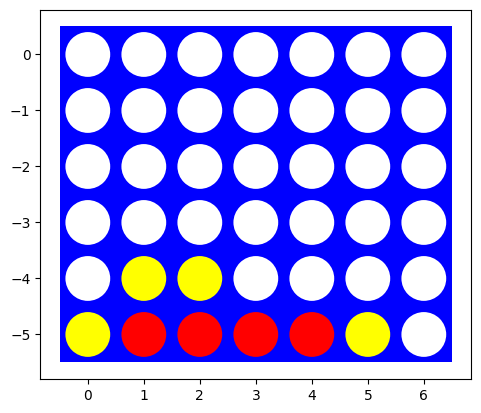

Moves for Player 1:
[4]
Moves for Player 2:
[]
Testing Sample Board 2
Player 1 has won!


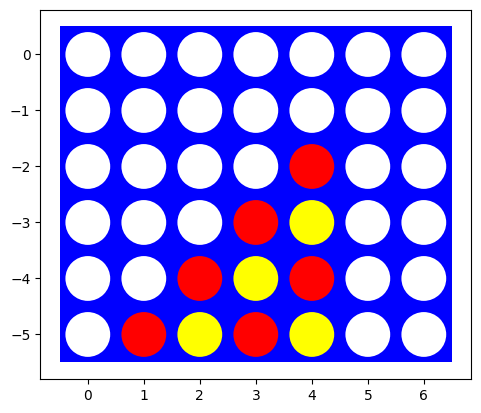

Moves for Player 1:
[4]
Moves for Player 2:
[]
Testing Sample Board 3
Player -1 has won!


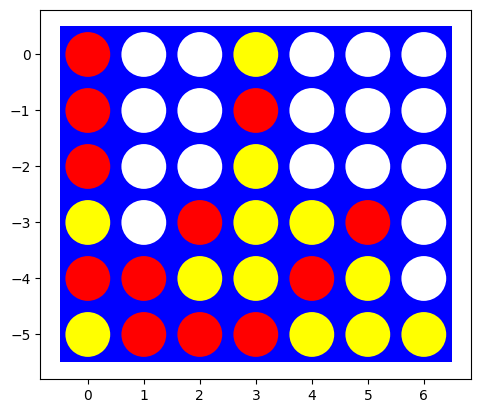

Moves for Player 1:
[4, 2, 3, 0, 0, 0, 5, 1]
Moves for Player 2:
[3, 3, 0, 3, 5, 5, 4, 6]
Testing Sample Board 4
Player 1 has won!


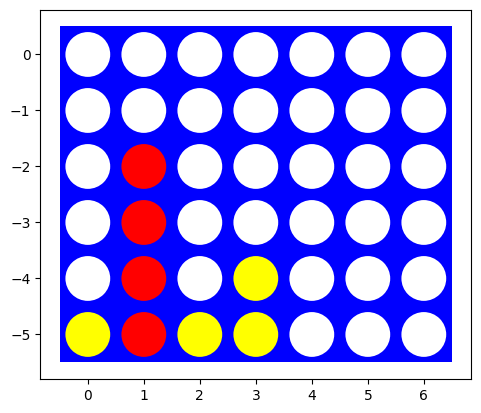

Moves for Player 1:
[1]
Moves for Player 2:
[]
Testing Sample Board 5
Player 1 has won!


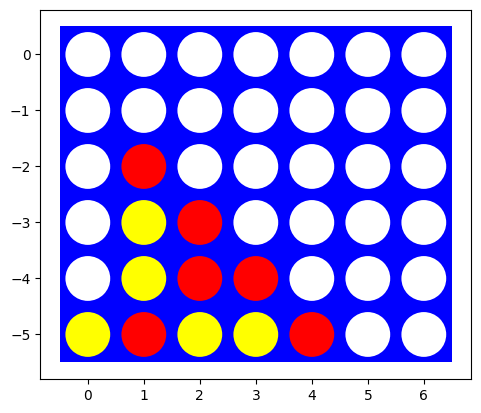

Moves for Player 1:
[4]
Moves for Player 2:
[]


In [ ]:
# Function to create an empty Connect Four board
def create_board(board_config):
    return np.array(board_config)

# Function to execute the game with depth experiment
def execute_game_with_depth_experiment(sample_boards, depth):
    for i, board_config in enumerate(sample_boards):
        print(f"Testing Sample Board {i + 1}")
        rows = len(board_config)
        cols = len(board_config[0])  # Assuming all rows have the same number of columns
        board = create_board(board_config)

        player = 1  # Starting player
        moves_player1 = []  # List to store player 1 moves
        moves_player2 = []  # List to store player 2 moves
        while not terminal(board):
          if player == 1:
              action = minimax_player(board, depth, player)  # Player 1's turn
              if action == 'mean':
                  moves_player1.append('mean')
              else:
                  moves_player1.append(action)
          else:
              action = minimax_player(board, depth, player)  # Player -1's turn
              if action == 'mean':
                  moves_player2.append('mean')
              else:
                  moves_player2.append(action)

          # Apply the selected move
          board = result(board, action, player)

          # Check if the move resulted in a win
          if check_winner(board, player):
              print(f"Player {player} has won!")
              break

          # Switch players
          player = -player

        # Print the final board state
        visualize(board)

        # Print the moves made by each player
        print("Moves for Player 1:")
        print(moves_player1)
        print("Moves for Player 2:")
        print(moves_player2)

        # Check if the game ended in a draw
        if terminal(board) and not check_winner(board, 1) and not check_winner(board, -1):
          print("The game ended in a draw!")

        print("=" * 30)

if __name__ == "__main__":
  # Sample boards for testing
    sample_boards = [
    # Horizontal win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, -1, -1, 0, 0, 0, 0],
    [-1, 1, 1, 1, 0, -1, 0]],
    # Positive slope diagonal win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, -1, 0, 0],
    [0, 0, 1, -1, 1, 0, 0],
    [0, 1, -1, 1, -1, 0, 0]],
    # Mean move win opportunity for player 1
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, -1, -1, 0, 0, 0],
    [-1, 1, 1, 1, -1, 0, 0]],
    # Vertical win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, -1, 0, 0, 0],
    [-1, 1, -1, -1, 0, 0, 0]],
    # Negative slope diagonal win opportunity for player 1 (WORKS!)
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, -1, 1, 0, 0, 0, 0],
    [0, -1, 1, 1, 0, 0, 0],
    [-1, 1, -1, -1, 0, 0, 0]]
    ]
  # Depth for the Minimax search
    depth = 4
  # Execute the game with depth experiment
    execute_game_with_depth_experiment(sample_boards, depth)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
import numpy as np
import time

# Function to create an empty board with specified rows and columns
def create_board(rows, cols):
    return np.zeros((rows, cols), dtype=int)

# Function to check if a column is valid for placing a disk
def is_valid_column(board, column):
    return board[0, column] == 0

# Function to find the next available row in a column
def find_next_row(board, column):
    for row in range(board.shape[0] - 1, -1, -1):
        if board[row, column] == 0:
            return row
    return -1

# Function to apply a player's move
def apply_player_move(board, column, player):
    row = find_next_row(board, column)
    board[row, column] = player

# Function to check for terminal states
def is_terminal(board):
    if np.all(board != 0):
        return True
    if check_winner(board, 1) or check_winner(board, -1):
        return True
    return False

# Function to check if a player has won
def check_winner(board, player):
    # Check horizontal
    for row in range(board.shape[0]):
        for col in range(board.shape[1] - 3):
            if np.all(board[row, col:col + 4] == player):
                return True

    # Check vertical
    for col in range(board.shape[1]):
        for row in range(board.shape[0] - 3):
            if np.all(board[row:row + 4, col] == player):
                return True

    # Check diagonal (positive slope)
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            if np.all(board[row:row + 4, col + np.arange(4)] == player):
                return True

    # Check diagonal (negative slope)
    for row in range(3, board.shape[0]):
        for col in range(board.shape[1] - 3):
            if np.all(board[row - np.arange(4), col + np.arange(4)] == player):
                return True

    # Check negative diagonal (backslash pattern)
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            if np.all(board[row:row + 4, col:col + 4].diagonal() == player):
                return True

    return False

# Function to get available actions
def get_available_actions(board):
    available_actions = []
    for col in range(board.shape[1]):
        if is_valid_column(board, col):
            available_actions.append(col)
    return available_actions

# Function to measure move time
def measure_move_time(board, player, column, move_function):
    start_time = time.time()
    move_function(board, column, player)
    end_time = time.time()
    return end_time - start_time

# Function to play Connect Four with depth experiment and measure move time
def play_connect4_with_time_experiment(start_cols, max_cols):
    for cols in range(start_cols, max_cols + 1):  # Iterate through different column sizes
        print(f"Testing with {cols} columns")
        board = create_board(6, cols)
        player = 1
        total_move_time = 0.0

        while not is_terminal(board):
            # Assume a simple random move for demonstration purposes
            available_actions = get_available_actions(board)
            column = np.random.choice(available_actions)
            move_time = measure_move_time(board, player, column, apply_player_move)
            total_move_time += move_time
            player *= -1

        print(f"Total move time for {cols} columns: {total_move_time} seconds")

# Run the experiment
start_columns = 4
max_columns = 8
play_connect4_with_time_experiment(start_columns, max_columns)


Testing with 4 columns
Total move time for 4 columns: 3.528594970703125e-05 seconds
Testing with 5 columns
Total move time for 5 columns: 2.6941299438476562e-05 seconds
Testing with 6 columns
Total move time for 6 columns: 3.123283386230469e-05 seconds
Testing with 7 columns
Total move time for 7 columns: 7.104873657226562e-05 seconds
Testing with 8 columns
Total move time for 8 columns: 9.012222290039062e-05 seconds


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
def minimax_ab(board, depth, alpha, beta, maximizing_player):
    if terminal(board) or depth == 0:
        return None, heuristic_evaluation(board, maximizing_player, 6, 7)

    best_action = None
    if maximizing_player:
        max_eval = -np.inf
        for action in actions(board):
            new_board = result(board, action, 1)
            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, False)
            if eval_score > max_eval:
                max_eval = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning
        return best_action, max_eval
    else:
        min_eval = np.inf
        for action in actions(board):
            new_board = result(board, action, -1)
            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True)
            if eval_score < min_eval:
                min_eval = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning
        return best_action, min_eval


def minimax_player(state, depth, player=None):
    maximizing_player = (player == 1)
    best_action = None
    alpha = -np.inf
    beta = np.inf

    if maximizing_player:
        best_score = -np.inf
        for action in actions(state):
            new_board = result(state, action, player)

            # Check for immediate mean move win
            if action == 'mean' and check_mean_move_win(new_board, player):
                return 'mean'

            _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, False)

            if eval_score is not None and eval_score > best_score:
                best_score = eval_score
                best_action = action
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break  # Beta pruning

    else:
        best_score = np.inf
        mean_move_available = False
        for action in actions(state):
            new_board = result(state, action, player)
            if action == 'mean':
                mean_move_available = True
                if check_winner(new_board, player):
                    return 'mean'  # If mean move can lead to a win, take it immediately
                _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True)
            else:
                _, eval_score = minimax_ab(new_board, depth - 1, alpha, beta, True)

            if eval_score is not None and eval_score < best_score:
                best_score = eval_score
                best_action = action
            beta = min(beta, eval_score)
            if beta <= alpha:
                break  # Alpha pruning

        if best_action is None and mean_move_available:
            best_action = 'mean'

    return best_action

# Define the function to let two heuristic search agents compete against each other
def compete_heuristic_agents(board_size, depth_player1, depth_player2, heuristic_player1, heuristic_player2):
    board = create_board(6, board_size)
    player = 1

    while not is_terminal(board):
        if player == 1:
            action = minimax_player(board, depth_player1, player)  # Pass depth_player1
            apply_player_move(board, action, player)
        else:
            action = minimax_player(board, depth_player2, player)  # Pass depth_player2
            apply_player_move(board, action, player)
        player *= -1

    if check_winner(board, 1):
        print("Player 1 wins!")
    elif check_winner(board, -1):
        print("Player 2 wins!")
    else:
        print("It's a draw!")

# Define the parameters for the competition
board_size = 7
depth_player1 = 4
depth_player2 = 3
heuristic_player1 = heuristic_evaluation
heuristic_player2 = heuristic_evaluation

# Compete the heuristic search agents
compete_heuristic_agents(board_size, depth_player1, depth_player2, heuristic_player1, heuristic_player2)

Player 2 wins!


---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
